# DLCV Homework 1
* R07944007 林良翰

In [1]:
import cv2
from IPython.display import display, Markdown, Latex
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import os
import os.path as osp
import pandas as pd
from scipy import ndimage
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors

plt.rcParams['text.color'] = 'k'
plt.rcParams['axes.labelcolor'] = 'k'
plt.rcParams['image.cmap'] = 'gray'

## 1. Bayes Decision Rule

* Find Best $T$

  $\begin{matrix}  & \min\limits _{ 2\le T\le 5 }{ \int _{ T }^{ \infty  }{ P\left( x|{ w }_{ 1 } \right) P\left( { w }_{ 1 } \right) dx } +\int _{ -\infty  }^{ T }{ P\left( x|{ w }_{ 2 } \right) P\left( { w }_{ 2 } \right) dx }  }  \end{matrix}$
  
  $ \begin{matrix} = & \min\limits _{ 2\le T\le 5 }{ \frac { 2 }{ 9 } \int _{ T }^{ \infty  }{ P\left( x|{ w }_{ 1 } \right) dx } +\frac { 7 }{ 9 } \int _{ -\infty  }^{ T }{ P\left( x|{ w }_{ 2 } \right) dx }  }  \end{matrix}$
  
  $ \begin{matrix} = & \min\limits _{ 2\le T\le 5 }{ \frac { 2 }{ 9 } \left[ \frac { 1 }{ 5 } \left( 5-T \right)  \right] +\frac { 7 }{ 9 } \left[ \frac { 1 }{ 7 } \left( T-2 \right)  \right]  }  \end{matrix}$
  
  $ \begin{matrix} = & \min\limits _{ 2\le T\le 5 }{ \frac { T }{ 15 }  }  \end{matrix}$
  
  $ \Rightarrow T=2,{ P }_{ e }=\frac { 2 }{ 15 }$
  
* Dicision Regions  

  $R_1$ : $x\lt 2$  
  
  $R_2$ : $x\ge 2$

## 2. PCA for Eigenfaces
* Reference: 
  * https://sandipanweb.wordpress.com/2018/01/06/eigenfaces-and-a-simple-face-detector-with-pca-svd-in-python/ 

In [2]:
def p2_read(dirpath='p2_data', n_persons=40, n_images=10, n_train=6, n_test=4, shuffle=False):
    # read images
    person_imgs, person_clss = [], []
    for i in range(n_persons):
        imgs, clss = [], []
        for j in range(n_images):
            imgs += [cv2.imread(osp.join(dirpath, "{:d}_{:d}.png".format(i + 1, j + 1)), 0)]
            clss += [i]
        person_imgs += [imgs]
        person_clss += [clss]
    person_imgs = np.array(person_imgs)
    person_clss = np.array(person_clss)
    
    # split training / testing
    indices = np.arange(n_train + n_test)
    if shuffle:
        np.random.shuffle(indices)
    train_indices, test_indices = indices[:n_train], indices[-n_test:]
    
    return person_imgs[:, train_indices], person_clss[:, train_indices], person_imgs[:, test_indices], person_clss[:, test_indices]

In [3]:
def err_cnt(y1, y2):
    return np.sum(np.sign(np.abs(y1 - y2)))


def pca(XT_raw):
    XT_mean = np.mean(XT_raw, axis=0)
    XT = XT_raw - XT_mean
    U, Sigma, VT = np.linalg.svd(XT, full_matrices=False)
    #XT_mean, VT = cv2.PCACompute(XT, mean=XT_mean.reshape(1, -1), maxComponents=n_persons * n_images)
    #print('XT = U * Sigma * VT:', XT.shape, U.shape, Sigma.shape, VT.shape)
    return XT, XT_mean, VT


def knn(k, points, Y, test_points):
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='auto').fit(points)
    distances, indices = nbrs.kneighbors(test_points)
    neighbors_Y, vote_Y= Y[indices], []
    for neighbors in neighbors_Y:
        vote_Y += [np.argmax(np.bincount(neighbors))]
    return np.array(vote_Y)

In [4]:
def p2(person_imgs_train, person_clss_train, person_imgs_test, person_clss_test, test=False):
    n_persons, n_images, h, w = person_imgs_train.shape
    XT_raw = person_imgs_train.reshape((n_persons * n_images, -1))
    XT, XT_mean, VT = pca(XT_raw)
    Y = person_clss_train.flatten()
    
    display(Markdown('### 2.1.'))
    rows, cols, su = 1, 5, 2
    fig, ax = plt.subplots(rows, cols, figsize=(cols * su, rows * su))
    
    for i in range(5):
        if i == 0:
            ax[i].imshow(XT_mean.reshape((h, w)))
            ax[i].set_title("Mean Face")
        else:
            ax[i].imshow(VT[i-1].reshape((h, w)))
            ax[i].set_title("Eigenface {:d}".format(i))

    plt.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.9, hspace=0.25, wspace=0.25)
    plt.setp(ax, xticks=[], yticks=[]); plt.show()
    
    # test 100 eigenfaces
    if test:
        rows, cols, su = 10, 10, 2
        fig, ax = plt.subplots(rows, cols, figsize=(cols * su, rows * su))        
        
        for i in range(100):
            r, c = int(i / 10), int(i % 10)
            ax[r, c].imshow(VT[i].reshape((h, w)))
            ax[r, c].set_title("{:d}".format(i + 1))
            
        plt.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.9, hspace=0.25, wspace=0.25)
        plt.setp(ax, xticks=[], yticks=[]); plt.show()

    display(Markdown('### 2.2. 2.3.'))
    rows, cols, su = 1, 5, 2
    fig, ax = plt.subplots(rows, cols, figsize=(cols * su, rows * su))
    original_img = XT[0]
    n_eigenfaces = [3, 45, 140, 229, len(VT)]
    
    for i, n in enumerate(n_eigenfaces):
        projection_T = np.dot(original_img, VT[:n].T)
        reconstruction_T = np.dot(projection_T, VT[:n])
        mse = np.mean((original_img - reconstruction_T) ** 2)
        ax[i].imshow(reconstruction_T.reshape((h, w)))
        ax[i].set_title("n={:d}".format(n))
        ax[i].set_xlabel('mse={:.2f}'.format(mse))
        
    plt.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.9, hspace=0.25, wspace=0.25)
    plt.setp(ax, xticks=[], yticks=[]); plt.show()
        
    display(Markdown('### 2.4.'))
    m_fold_cross_validation = 3
    fold_size = int(n_images / m_fold_cross_validation)
    indices = np.arange(n_images)
    
    n_eigenfaces = [3, 45, 140]
    k_nearest_neighbors = [1, 3, 5]
    errors = np.zeros((len(n_eigenfaces), len(k_nearest_neighbors)))
    
    for m in range(m_fold_cross_validation):
        # split train / validation to each person, not to all images (XT)
        train_indices, val_indices = indices[fold_size:], indices[:fold_size]
        XT_raw_train = person_imgs_train[:, train_indices].reshape((n_persons * len(train_indices), -1))
        XT_raw_val   = person_imgs_train[:, val_indices].reshape((n_persons * len(val_indices), -1))
        Y_train = person_clss_train[:, train_indices].flatten()
        Y_val   = person_clss_train[:, val_indices].flatten()
        
        # compute eigenfaces by training data
        XT_train, XT_train_mean, VT_train = pca(XT_raw_train)
        
        for i, n in enumerate(n_eigenfaces):
            # project training and validation data onto eigen space
            V_train = VT_train[:n].T
            PT_train = np.dot(XT_train, V_train)
            PT_val = np.dot(XT_raw_val - XT_train_mean, V_train)
            
            for j, k in enumerate(k_nearest_neighbors):
                # find k-nearest-neighbors for each validation data
                Y_val_pred = knn(k, PT_train, Y_train, PT_val)
                err_val = err_cnt(Y_val_pred, Y_val)
                #print('fold={:d}, #eigenfaces={:d}, #neighbors={:d}, err={:d}'.format(m, n, k, err_val))
                errors[i, j] += err_val
                
        indices = np.roll(indices, -fold_size)
    
    display(Markdown('* Error Count'))
    errors = errors / m_fold_cross_validation
    display(pd.DataFrame(np.round(errors, 2), index=['n=%d' % n for n in n_eigenfaces], columns=['k=%d' % k for k in k_nearest_neighbors]))
    
    display(Markdown('* Accuracy'))
    accuracy = 1 - errors / len(Y_val)
    display(pd.DataFrame(np.round(accuracy, 4), index=['n=%d' % n for n in n_eigenfaces], columns=['k=%d' % k for k in k_nearest_neighbors]))
    
    best_n, best_k = np.where(errors == np.min(errors))
    best_n, best_k = n_eigenfaces[best_n[0]], k_nearest_neighbors[best_k[0]]
    display(Markdown('* Best $(n, k)$ = $({:d}, {:d})$'.format(best_n, best_k)))
    
    display(Markdown('### 2.5.'))
    n_persons_test, n_images_test, _, _ = person_imgs_test.shape
    XT_raw_test = person_imgs_test.reshape((n_persons_test * n_images_test, -1)) # reshape test data
    Y_test = person_clss_test.flatten() # gt of test data
    
    XT_train, XT_train_mean, VT_train = pca(XT_raw) # compute eigenfaces from training data
    PT = np.dot(XT, VT_train[:best_n].T) # project to eigen space
    PT_test = np.dot(XT_raw_test - XT_train_mean, VT_train[:best_n].T) # project to eigen space
    
    Y_test_pred = knn(best_k, PT, Y, PT_test)
    err_test = err_cnt(Y_test_pred, Y_test)
    accuracy = 1 - err_test / len(Y_test)
    display(Markdown(('* Test Error = ${:d}$'.format(err_test))))
    display(Markdown(('* Test Accuracy = ${:.2f}\%$'.format(accuracy * 100))))

### 2.1.

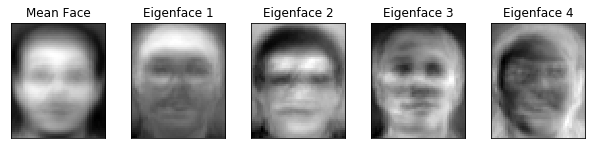

### 2.2. 2.3.

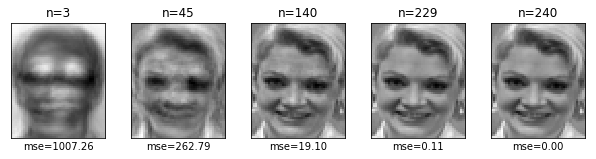

### 2.4.

* Error Count

,k=1,k=3,k=5
n=3,25.67,32.33,38.33
n=45,5.67,13.33,17.33
n=140,5.33,11.67,19.33


* Accuracy

,k=1,k=3,k=5
n=3,0.6792,0.5958,0.5208
n=45,0.9292,0.8333,0.7833
n=140,0.9333,0.8542,0.7583


* Best $(n, k)$ = $(140, 1)$

### 2.5.

* Test Error = $10$

* Test Accuracy = $93.75\%$

In [5]:
p2(*p2_read(), test=False)

## 3. Visual Bag-of-Words

In [6]:
def p3_read(dirpath='p3_data', n_classes=4, n_images=500, n_train=375, n_test=125, shuffle=False):
    # read images
    clss_names = []
    for d in os.listdir(dirpath):
        clss_names += [d] if osp.isdir(osp.join(dirpath, d)) else []
    n_classes = len(clss_names)

    imgs = []
    for c in clss_names:
        clss_imgs = []
        clss_dir = osp.join(dirpath, c)
        for img_fname in np.sort(os.listdir(clss_dir)):
            clss_imgs += [cv2.cvtColor(cv2.imread(osp.join(clss_dir, img_fname)), cv2.COLOR_BGR2RGB)]
        imgs += [clss_imgs]
    
    imgs = np.array(imgs)
    clss = np.repeat(np.arange(n_classes), n_images).reshape(n_classes, -1)
    
    # split training / testing
    indices = np.arange(n_train + n_test)
    if shuffle:
        np.random.shuffle(indices)
    train_indices, test_indices = indices[:n_train], indices[-n_test:]
    
    return imgs[:, train_indices], imgs[:, test_indices], clss[:, train_indices], clss[:, test_indices], clss_names    

In [7]:
def split_patches(X, Y, p_rows=4, p_cols=4, test=False):
    n_classes, n_images, h, w, channel = X.shape
    ph, pw = int(h / p_rows), int(w / p_cols)
    X_patches = []
    
    for r in range(p_rows):
        for c in range(p_cols):
            X_patches += [X[:, :, r*ph:(r+1)*ph, c*pw:(c+1)*pw]]
            
    X_patches = np.swapaxes(np.swapaxes(np.array(X_patches), 0, 2), 0, 1)
    Y_patches = np.repeat(Y[:, :, np.newaxis], p_rows * p_cols, axis=2)
    
    if test:
        print(X_patches.shape)
        print(Y_patches.shape)
        fig, ax = plt.subplots(p_rows, p_cols, figsize=(8, 8))
        for r in range(p_rows):
            for c in range(p_cols):
                ax[r, c].imshow(X_patches[0, 0, r * p_rows + c])
                ax[r, c].set_title(Y_patches[0, 0, r * p_rows + c])
        plt.show()
    
    return X_patches, Y_patches

def bow(X_patches, centers, n_patches):
    k_centers = len(centers)
    
    # find distances between patch and 15 different centers
    distances = np.array([np.sqrt(np.sum((X_patches - c) ** 2, axis=1)) for c in centers])

    # normalize distances
    distances_norm = distances / np.linalg.norm(distances, 2, axis=0)

    # put index of center distances to last dimension, and reshape back to (n_images, n_patches, k_centers)
    distances_norm = distances_norm.T.reshape(-1, n_patches, k_centers)

    # do softmax at patch axis to get features of k_centers dimension
    features = np.max(distances_norm, axis=1)
    
    return features

In [19]:
def p3(X_train, X_test, Y_train, Y_test, class_names):
    # split patches
    X_train_img_patches, Y_train_img_patches = split_patches(X_train, Y_train, 4, 4, test=0)
    X_test_img_patches, Y_test_img_patches = split_patches(X_test, Y_test, 4, 4, test=0)
    
    display(Markdown('### 3.1.'))
    n_classes, n_train, n_patches, h, w, channel = X_train_img_patches.shape
    rows, cols, su = 3, 5, 2
    fig, ax = plt.subplots(rows, cols, figsize=(cols * su, rows * su))
    np.random.seed(1028)
    
    for c in range(cols):
        ci = c % n_classes # class index
        ii = np.random.randint(n_train) # image index
        img_patches = X_train_img_patches[ci, ii]
        img_patch_indices = np.arange(n_patches)
        np.random.shuffle(img_patch_indices)
        
        for r in range(rows):
            pi = img_patch_indices[r]
            ax[r, c].imshow(img_patches[pi])
            ax[r, c].set_title('{}-{:d}-{:d}'.format(class_names[ci], ii, pi))
    
    plt.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.9, hspace=0.2, wspace=0.3)
    plt.setp(ax, xticks=[], yticks=[]); plt.show()
    
    display(Markdown('### 3.2.'))
    # flatten all patches to 1D
    n_classes, n_train, n_patches, h, w, channel = X_train_img_patches.shape
    X_train_patches = X_train_img_patches.reshape(n_classes * n_train * n_patches, h * w * channel)
    Y_train_patches = Y_train_img_patches.flatten()
    n_classes, n_test, n_patches, h, w, channel = X_test_img_patches.shape
    X_test_patches = X_test_img_patches.reshape(n_classes * n_test * n_patches, h * w * channel)
    Y_test_patches = Y_test_img_patches.flatten()
    
    # k-means-clustering
    k_centers, max_iter = 15, 100
    kmeans = KMeans(k_centers, max_iter=max_iter, n_jobs=-1).fit(X_train_patches)
    centers, labels = kmeans.cluster_centers_, kmeans.labels_
    
    # PCA
    n_best = 3
    X_train_patches_normalized, X_train_patches_mean, VT = pca(X_train_patches)
    PT_train_patches = np.dot(X_train_patches_normalized, VT[:n_best].T)
    PT_centers = np.dot(centers - X_train_patches_mean, VT[:n_best].T)
    
    # plot results
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    center_indices = np.arange(len(PT_centers))
    np.random.shuffle(center_indices)
    
    for i, ci in enumerate(center_indices[:6]):
        color = 'C%d' % (i % 10)
        cx, cy, cz = PT_centers[ci]
        ax.scatter(cx, cy, cz, marker='X', color=color, s=100) # plot center
        pt = PT_train_patches[labels == ci]
        px, py, pz = pt[:, 0], pt[:, 1], pt[:, 2]
        ax.scatter(px, py, pz, marker='o', color=color, s=0.1) # plot corresponding points
    
    ax.set_title('K-Means Clustering')
    plt.show()
    
    display(Markdown('### 3.3.'))
    img_features_train = bow(X_train_patches, centers, n_patches)
    class_img_features_train = img_features_train.reshape(n_classes, -1, k_centers) # add class axis
    
    np.random.seed(1028)
    rows, cols, su = 1, 4, 4
    fig, ax = plt.subplots(rows, cols, figsize=(cols * su, rows * su))
    
    for c in range(cols):
        ii = np.random.randint(n_train)
        ax[c].bar(np.arange(k_centers) + 1, height=class_img_features_train[c, ii])
        ax[c].set_title('{}-{:d}'.format(class_names[c], ii))
    plt.show()
    
    display(Markdown('### 3.4.'))
    k_neighbors = 5
    
    # get test images features
    img_features_test = bow(X_test_patches, centers, n_patches)
    
    # KNN
    n_test = len(img_features_test)
    Y_test_pred = knn(k_neighbors, img_features_train, Y_train.flatten(), img_features_test)
    accuracy = 1 - err_cnt(Y_test_pred, Y_test.flatten()) / n_test
    display(Markdown('* Test Accuracy = ${:.2f}\%$'.format(accuracy * 100)))

### 3.1.

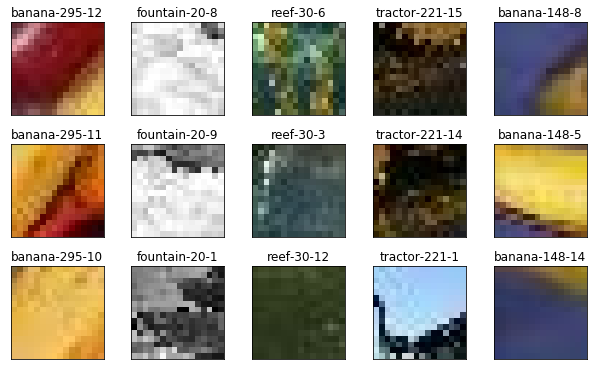

### 3.2.

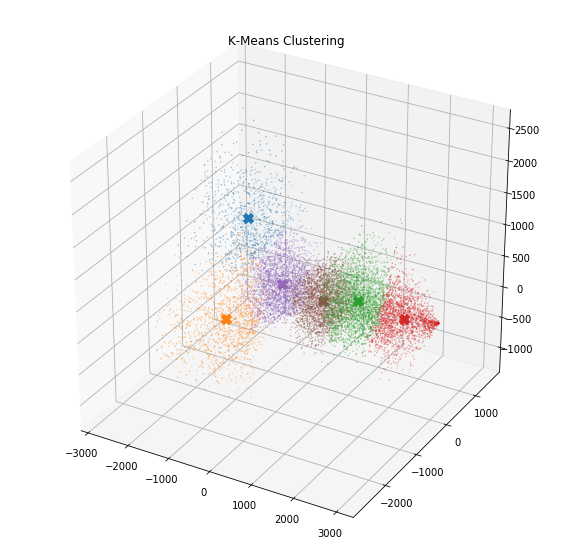

### 3.3.

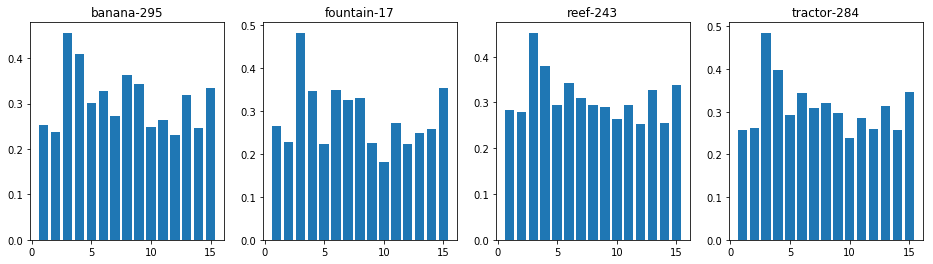

### 3.4.

* Test Accuracy = $53.80\%$

In [20]:
p3(*p3_read())

## 4. Image Filtering

### 4.1.

$G\left( x \right) =\frac { 1 }{ \sqrt { 2\pi { \sigma  }^{ 2 } }  } { e }^{ -\frac { { x }^{ 2 } }{ 2{ \sigma  }^{ 2 } }  }$

$G\left( y \right) =\frac { 1 }{ \sqrt { 2\pi { \sigma  }^{ 2 } }  } { e }^{ -\frac { y^{ 2 } }{ 2{ \sigma  }^{ 2 } }  }$

$G\left( x \right) G\left( y \right) =\frac { 1 }{ { \left( \sqrt { 2\pi { \sigma  }^{ 2 } }  \right)  }^{ 2 } } { e }^{ -\frac { { x }^{ 2 } }{ 2{ \sigma  }^{ 2 } } -\frac { { y }^{ 2 } }{ 2{ \sigma  }^{ 2 } }  }=\frac { 1 }{ 2\pi { \sigma  }^{ 2 } } { e }^{ -\frac { { x }^{ 2 }+{ y }^{ 2 } }{ 2{ \sigma  }^{ 2 } }  }=G\left( x,y \right)$

In [10]:
def p4_read(filepath='lena.png'):
    return cv2.imread(filepath, 0)

In [11]:
def gm(I):
    r, l, t, b = np.zeros(I.shape), np.zeros(I.shape), np.zeros(I.shape), np.zeros(I.shape)
    r[:, :-1] = I[:, 1:]; r[:, -1] = I[:, -1]
    l[:, 1:] = I[:, :-1]; l[:, 0] = I[:, 0]
    t[1:] = I[:-1]; t[0] = I[0]
    b[:-1] = I[1:]; b[-1] = I[-1]
    I_x = r - l
    I_y = b - t
    I_m = np.sqrt(I_x ** 2 + I_y ** 2).astype(np.uint8)

    return I_m, I_x, I_y

In [12]:
def p4(I):
    display(Markdown('### 4.2.'))

    Ig = cv2.GaussianBlur(I, (3, 3), sigmaX=(2 * np.log(2)))

    imgs = [I, Ig, I - Ig]
    titles = ['Original ($I$)', 'Gaussian Blur ($I_G ,\sigma=2\ln{2}$)', 'Difference ($I - I_G$)']
    rows, cols, su = 1, 3, 4
    fig, ax = plt.subplots(rows, cols, figsize=(cols * su, rows * su))

    for c in range(cols):
        ax[c].imshow(imgs[c]);
        ax[c].set_title(titles[c])

    fig.patch.set_alpha(1.0)
    plt.setp(ax, xticks=[], yticks=[]); plt.show()

    display(Markdown('### 4.3.'))
    I_m, I_x, I_y = gm(I)
    
    imgs = [I, I_x, I_y]
    titles = ['Original ($I$)', '$I_x$', '$I_y$']
    rows, cols, su = 1, len(imgs), 4
    fig, ax = plt.subplots(rows, cols, figsize=(cols * su, rows * su))

    for c in range(cols):
        ax[c].imshow(imgs[c]);
        ax[c].set_title(titles[c])

    fig.patch.set_alpha(1.0)
    plt.setp(ax, xticks=[], yticks=[]); plt.show()

    display(Markdown('### 4.4.'))
    Ig_m, Ig_x, Ig_y = gm(Ig)

    imgs = [I, I_m, Ig_m, I_m - Ig_m]
    titles = ['Original ($I$)', 'Gradient Magnitude ($I_m$)', 'Gradient Magnitude ($I_{Gm}$)', 'Difference ($I_m - I_{Gm}$)']
    rows, cols, su = 1, len(imgs), 4
    fig, ax = plt.subplots(rows, cols, figsize=(cols * su, rows * su))

    for c in range(cols):
        ax[c].imshow(imgs[c])
        ax[c].set_title(titles[c])

    fig.patch.set_alpha(1.0)
    plt.setp(ax, xticks=[], yticks=[]); plt.show()

### 4.2.

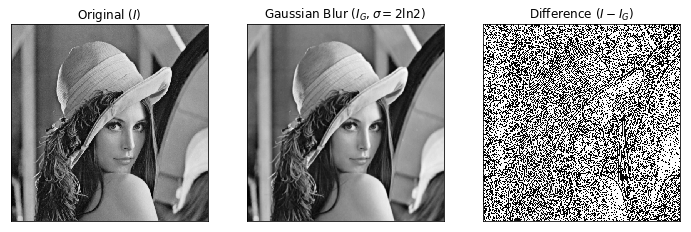

### 4.3.

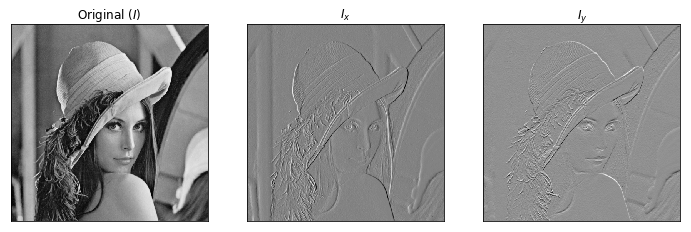

### 4.4.

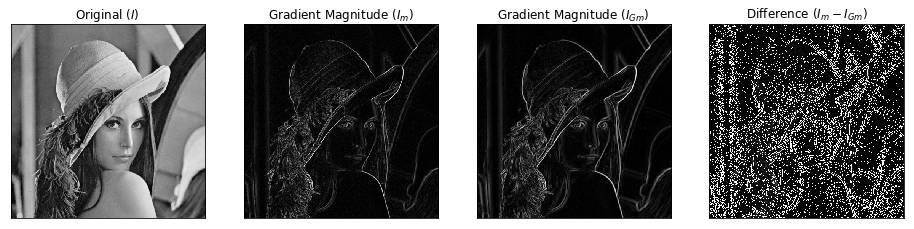

In [13]:
p4(p4_read())